# 摘要

# 理论模型

由于鸡蛋的需求比较稳定，鸡蛋价格一般由产蛋成本决定。

鸡蛋的成本包括蛋鸡的饲料成本，雏鸡费以及其他成本，其中饲料成本和雏鸡费占总成本的 75-90%。饲料成本占总支出的 60-70%，是决定鸡蛋价格的主要因素。

蛋鸡养殖的主要成本包括：鸡苗、饲料、水、电、人工和防疫等费用。除了鸡蛋出售收入，还有鸡粪以及蛋鸡淘汰以后变卖的收入。一只蛋鸡从鸡苗到产蛋到退役，整个过程经历 17 个月。蛋鸡在生命周期内产蛋 37.5 斤，消耗饲料约 122.7 斤，鸡苗成本约 3 元，防疫费支出 3 元，水电费支出 0.5 元，鸡粪获利 3.4 元，淘汰鸡出售约 16.4 元。

鸡蛋的盈亏平衡价格 = (饲料费用 + 鸡苗成本 + 防疫费 + 水电费 - 鸡粪收入 - 淘汰鸡收入) / 37.5

产蛋成本中的主要变量是饲料价格，蛋鸡饲料的典型配方是 62% 的玉米，31% 的豆粕和 7% 的预混料（麦麸、磷酸氢钙、石粉、食盐以及其他添加剂），预混料价格大约在 2.5 元/斤，饲料价格公式为：

饲料价格（元/斤） = 0.62 × 玉米价格（元/斤） + 0.31 × 豆粕价格（元/斤） + 0.175（元/斤）

鸡蛋、玉米、豆粕价格的联系公式：

鸡蛋盈亏平衡价格（元/斤） = 2.02864 × 玉米价格（元/斤） + 1.01432 × 豆粕价格（元/斤） + 0.218（元/斤）

即 2.02864 = 0.62 * 122.7 / 37.5, 1.01432 = 0.31 * 122.7 / 37.5, 0.218 = (0.175 * 122.7 + 3 + 3 + 0.5 - 3.4 - 16.4) / 37.5

对于期货，鸡蛋的报价是元/500千克，玉米和豆粕的报价是元/吨，从而期货价格的联系公式为：

鸡蛋价格 = 1.01432 × 玉米价格 + 0.50716 × 豆粕价格 + 218

# 实证分析

In [2]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

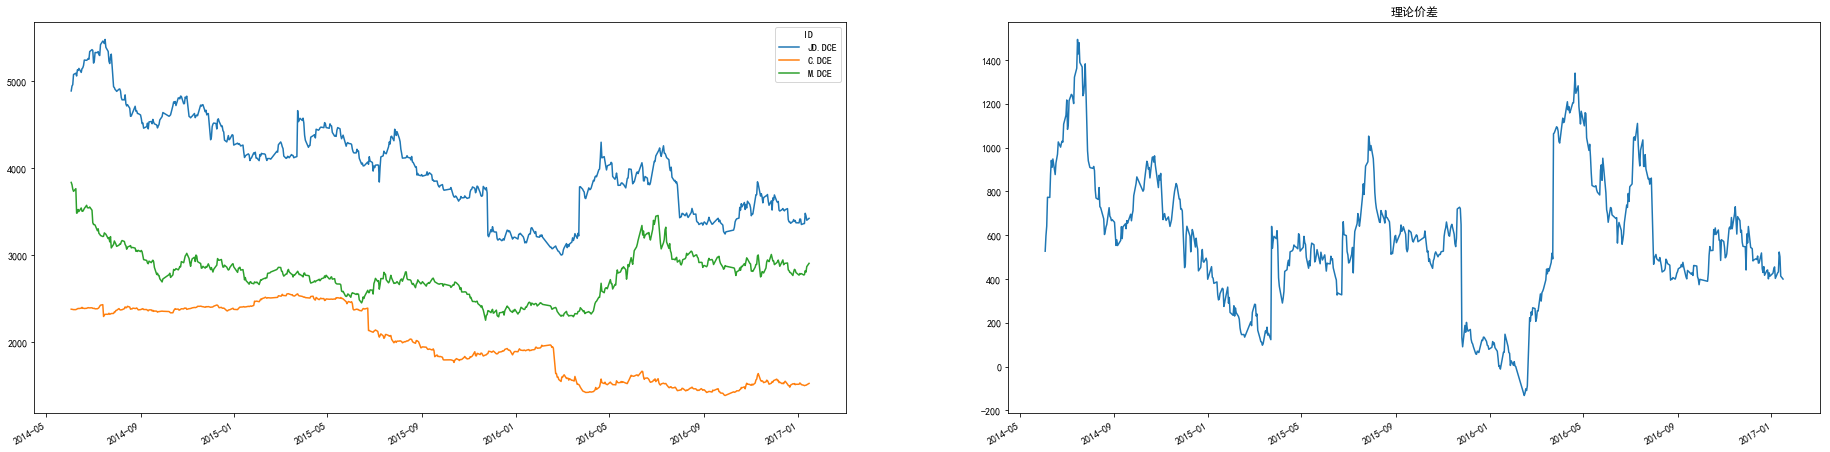

In [20]:
# 参数设置和数据准备
Exchange = "DCE"
# IDs = ["JD01.DCE", "C01.DCE", "M01.DCE"]# 鸡蛋, 玉米, 豆粕连一合约
IDs = ["JD.DCE", "C.DCE", "M.DCE"]# 鸡蛋, 玉米, 豆粕主力合约
TheoryHedgeRatio = np.array([1, -1.01432, -0.50716])
StartDT = dt.datetime(2014, 6, 1)# 回测开始日期
EndDT = dt.datetime(2017, 1, 16)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()

# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差");

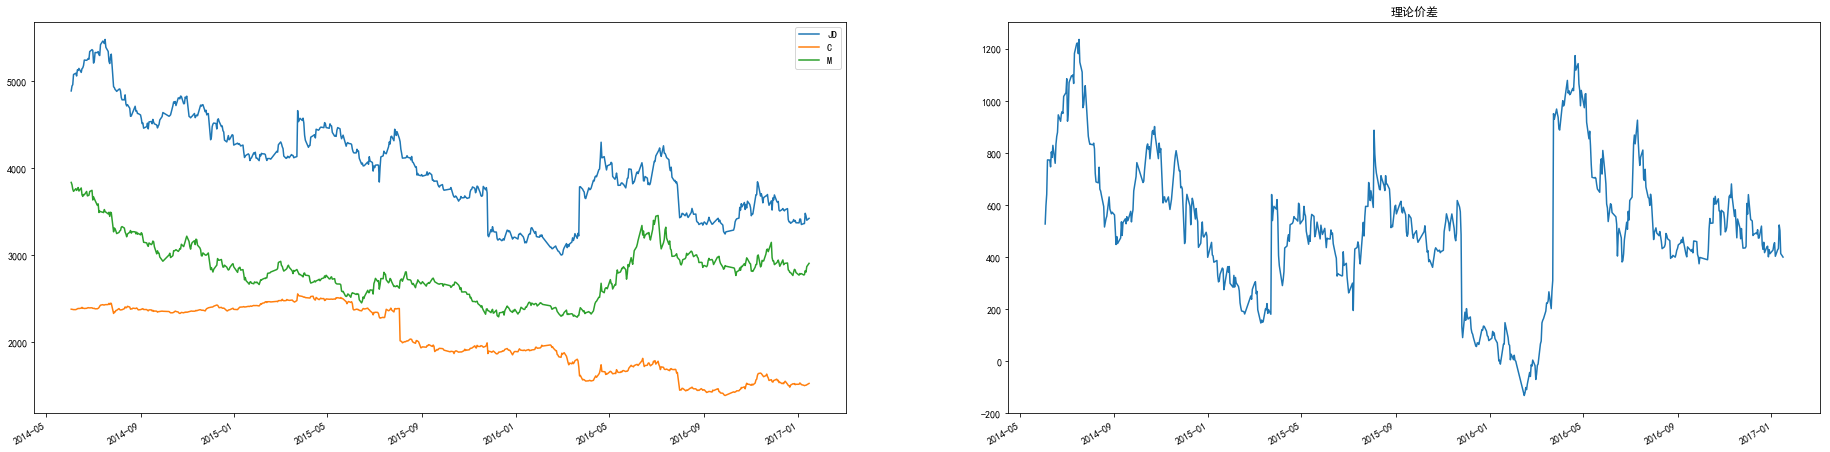

In [21]:
# 使用对齐交割月的价格数据
import re
Exchange = "DCE"
BenchmarkID = "JD.DCE"# 作为标准的主力合约
Codes = ["JD", "C", "M"]# 合约代码
ExchangeSuffix = ["DCE", "DCE", "DCE"]# 交易所后缀
TheoryHedgeRatio = np.array([1, -1.01432, -0.50716])
StartDT = dt.datetime(2014, 6, 1)# 回测开始日期
EndDT = dt.datetime(2017, 1, 16)# 回测截止日期
PriceFactor = "收盘价(元)"

# 以焦炭的主力合约为准
WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[BenchmarkID], dts=DTs).iloc[0,:,:]
for i, iCode in enumerate(Codes):
    FutureIDMap[iCode] = FutureIDMap.iloc[:, 0].apply(lambda x: iCode+re.sub("\D", "", x)+"."+ExchangeSuffix[i])
FutureIDMap.pop(BenchmarkID)
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()

# 生成连续合约的价格
CCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_type="价格不变") for iID in FutureIDMap.columns}
CCPrice = pd.DataFrame(CCPrice).loc[:, FutureIDMap.columns]
# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差");

In [5]:
# --------平稳性检验--------
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, 0], regression='c', autolag="BIC")
print("----------- 鸡蛋价格 ADF Test ----------",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")
ADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, 1], regression='c', autolag="BIC")
print("----------- 玉米价格 ADF Test ----------",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")
ADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, 2], regression='c', autolag="BIC")
print("----------- 豆粕价格 ADF Test ----------",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")
ADFTest = sm.tsa.stattools.adfuller(np.diff(CCPrice.values[:, 0]), regression='c', autolag="BIC")
print("----------- Diff(鸡蛋价格, 1) ADF Test ----------",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")
ADFTest = sm.tsa.stattools.adfuller(np.diff(CCPrice.values[:, 1]), regression='c', autolag="BIC")
print("----------- Diff(玉米价格, 1) ADF Test ----------",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")
ADFTest = sm.tsa.stattools.adfuller(np.diff(CCPrice.values[:, 2]), regression='c', autolag="BIC")
print("----------- Diff(豆粕价格, 1) ADF Test ----------",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")

----------- 鸡蛋价格 ADF Test ----------
Statistic : -1.690742
pvalue : 0.435889
usedlag : 0
----------- 玉米价格 ADF Test ----------
Statistic : -0.592292
pvalue : 0.872714
usedlag : 0
----------- 豆粕价格 ADF Test ----------
Statistic : -3.659790
pvalue : 0.004716
usedlag : 0
----------- Diff(鸡蛋价格, 1) ADF Test ----------
Statistic : -26.138047
pvalue : 0.000000
usedlag : 0
----------- Diff(玉米价格, 1) ADF Test ----------
Statistic : -25.709401
pvalue : 0.000000
usedlag : 0
----------- Diff(豆粕价格, 1) ADF Test ----------
Statistic : -25.342597
pvalue : 0.000000
usedlag : 0


----------- 鸡蛋-玉米-豆粕 Cointegration Johansen Test: r<=0 -----------
Trace Statistic: 26.250346
Critical Values (90%, 95%, 99%): [27.0669 29.7961 35.4628]
Maximum Eigenvalue Statistic Statistic: 19.266670
Critical Values (90%, 95%, 99%): [18.8928 21.1314 25.865 ]
----------- 鸡蛋-玉米-豆粕 Cointegration Johansen Test: r<=1 -----------
Trace Statistic: 6.983676
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 6.248412
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- 鸡蛋-玉米-豆粕 Cointegration Johansen Test: r<=2 -----------
Trace Statistic: 0.735264
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 0.735264
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
对冲比例: [ 1.         -1.10494307 -1.40318835]


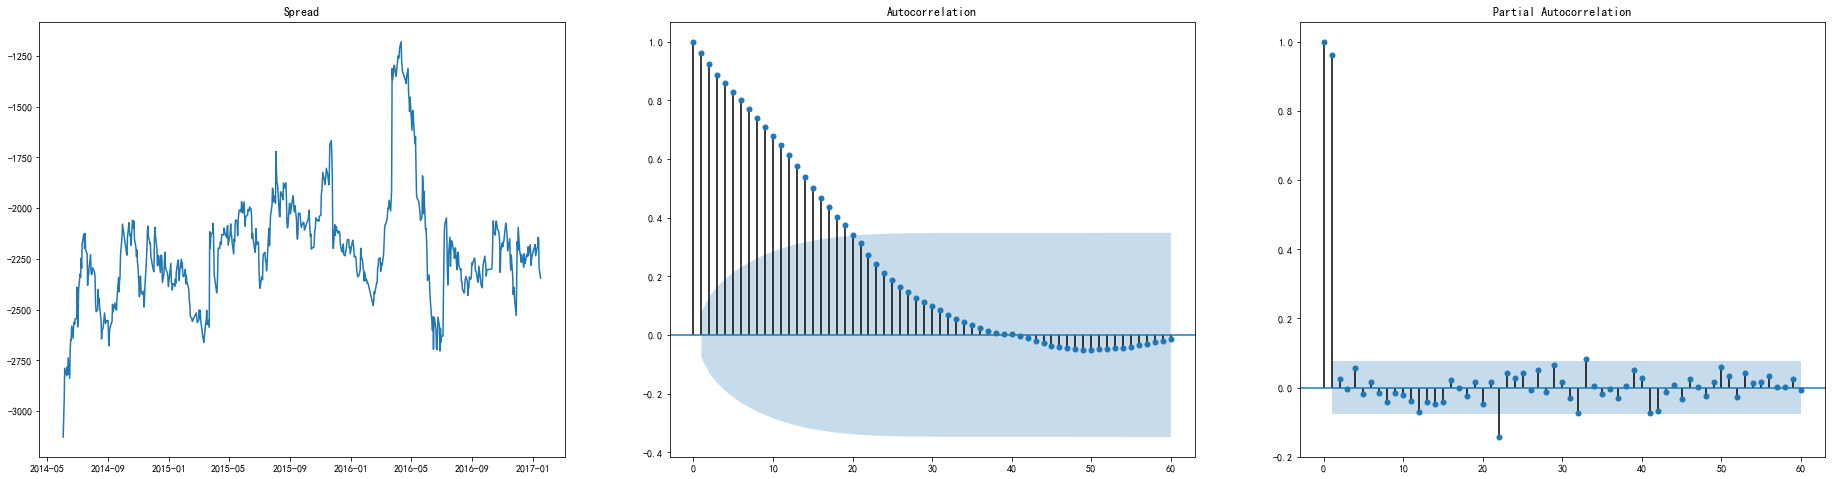

In [14]:
# --------协整检验--------
CointJohansenTest = sm.tsa.var.vecm.coint_johansen(CCPrice.values, det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print(("----------- 鸡蛋-玉米-豆粕 Cointegration Johansen Test: r<=%d -----------" % (i, )),
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

Spread = (CCPrice * HedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(Spread)
Axes[0].set_title("Spread")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

HalfLife: 27.146333


,0
起始时点,2014-06-03 00:00:00
结束时点,2017-01-16 00:00:00
时点数,644
总收益率,0.114418
年化收益率,0.0421383
年化波动率,0.0555102
Sharpe比率,0.75911
胜率,0.812112
最大回撤率,0.0751658
最大回撤开始时点,2016-02-22 00:00:00


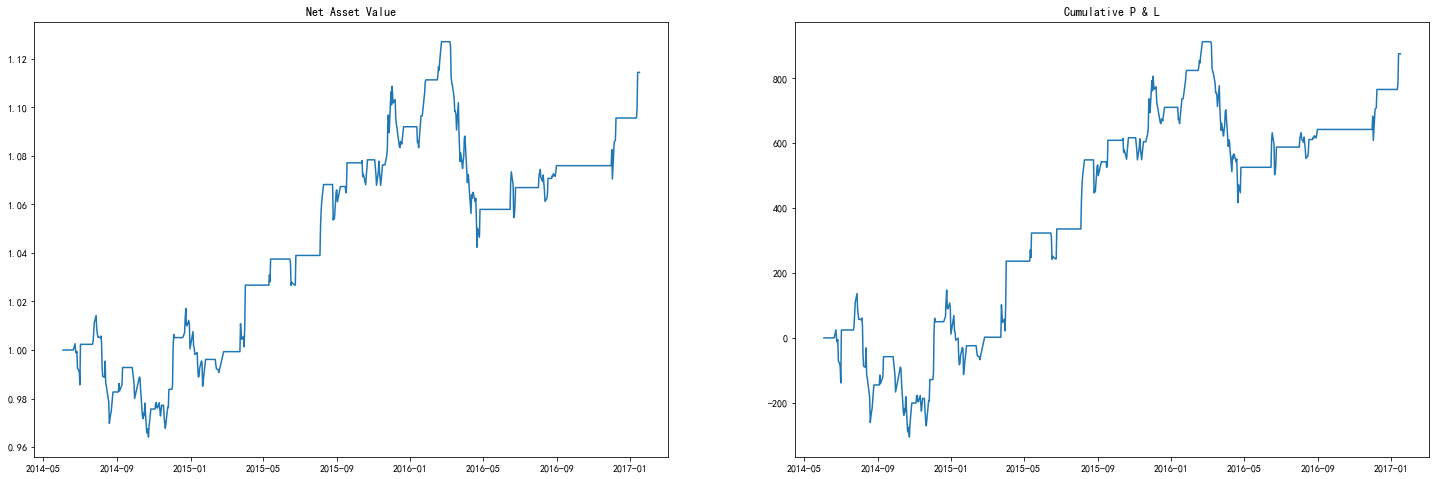

In [17]:
# --------Spread 策略--------
EntryThreshold, ExitThreshold = 2, 0
NumRatio = np.array([1, -1.01432, -0.50716])
# NumRatio = HedgeRatio

# 生成信号
Spread = (CCPrice * NumRatio).sum(axis=1)
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)
LookBack = 10
# LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.full(shape=(CCPrice.shape[0], ), fill_value=np.nan)
# 空头信号
Mask = (Zscore.values>EntryThreshold)
NumUnits[Mask] = -1
# 多头信号
Mask = (Zscore.values<-EntryThreshold)
NumUnits[Mask] = 1
# 平仓信号
PreNumUnits = pd.Series(NumUnits).fillna(method="pad").values
NumUnits[(PreNumUnits==1) & (Zscore.values>=-ExitThreshold)] = 0
NumUnits[(PreNumUnits==-1) & (Zscore.values<=ExitThreshold)] = 0
# 填充缺失
NumUnits[0] = (0 if pd.isnull(NumUnits[0]) else NumUnits[0])
NumUnits = pd.Series(NumUnits).fillna(method="pad").values
# 策略回测
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(NumRatio.shape[0], axis=1) * NumRatio
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * CCPrice.values / AdjCCPrice.values, AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");